# Installing Darts Library and Regraded Version of Matplotlib
Could not use Darts Library with the current version of Matplotlib - 3.5.3

Had to degrade to version - 3.1.3

https://stackoverflow.com/questions/64862818/cannot-import-name-png-from-matplotlib

In [9]:
! pip install darts
! pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 7.5 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nfoursid 1.0.1 requires matplotlib>=3.3, but you have matplotlib 3.1.3 which is incompatible.
darts 0.22.0 requires matplotlib>=3.3.0, but you have matplotlib 3.1.3 which is incompatible.


# Necessary Imports for the Project

In [7]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
)
from darts.metrics import mape, smape
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

# Datasets
**AirPassegersDataset** - contains the monthly number of air passengers

**MonthlyMilkDataset** - contains the monthly milk production per cow

**Common Characteristics**


*   They both have a monthly frequency with a marked yearly periodicity and upward trend
*   They contain values of a comparable order of magnitude (completely coincidentaly)



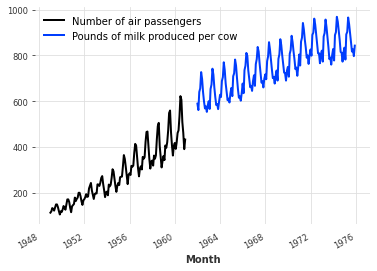

In [10]:
series_air = AirPassengersDataset().load()
series_milk = MonthlyMilkDataset().load()

series_air.plot(label="Number of air passengers")
series_milk.plot(label="Pounds of milk produced per cow")
plt.legend()

# Preprocessing
Using the Scaler class to normalise both of our time series between 0 and 1

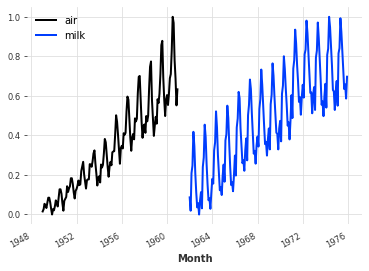

In [11]:
scaler_air, scaler_milk = Scaler(), Scaler()
series_air_scaled = scaler_air.fit_transform(series_air)
series_milk_scaled = scaler_milk.fit_transform(series_milk)

series_air_scaled.plot(label="air")
series_milk_scaled.plot(label="milk")
plt.legend()

# Train / Validation split

In [12]:
train_air, val_air = series_air_scaled[:-36], series_air_scaled[-36:]
train_milk, val_milk = series_milk_scaled[:-36], series_milk_scaled[-36:]

# Training a Model on Single Time Series

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
49.575    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


Predicting: 3it [00:00, ?it/s]

MAPE = 8.02%


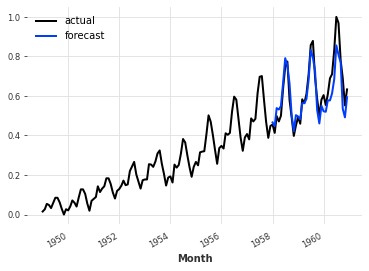

In [13]:
model_air = NBEATSModel(
    input_chunk_length=24, output_chunk_length=12, n_epochs=200, random_state=0
)

model_air.fit(train_air, verbose=True)

pred = model_air.predict(n=36)

series_air_scaled.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(series_air_scaled, pred)))

We have built an N-BEATS model that has a lookback window of 24 points (input_chunk_length=24) and predicts the next 12 points (output_chunk_length=12). We chose these values so it'll make our model produce successive predictions for one year at a time, looking at the past two years.

# Training a Model on Multiple Time Series

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
49.575    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Predicting: 7it [00:00, ?it/s]

MAPE = 7.16%


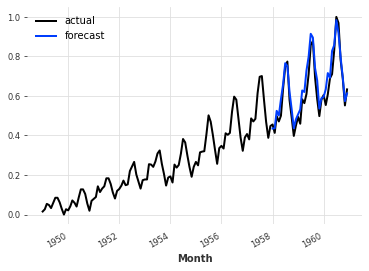

In [14]:
model_air_milk = NBEATSModel(
    input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=0
)

model_air_milk.fit([train_air, train_milk], verbose=True)

#Producing Forecasts After the End of a Series
pred = model_air_milk.predict(n=36, series=train_air)

series_air_scaled.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(series_air_scaled, pred)))

We have fit N-BEATS model instance on our two time series (air passengers and milk production). Since using two series of (roughly) the same length (roughly) doubles the training dataset size, we have used half of the number of epochs

Predicting: 7it [00:00, ?it/s]

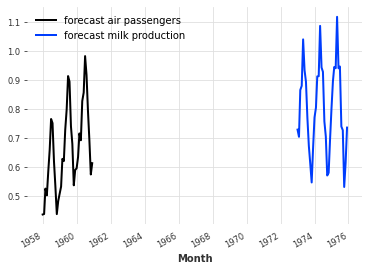

In [16]:
pred_list = model_air_milk.predict(n=36, series=[train_air, train_milk])
for series, label in zip(pred_list, ["air passengers", "milk production"]):
    series.plot(label=f"forecast {label}")
plt.legend()

We can give a list of series in argument to the predict() function, in which case it will return a list of forecast series. For example, we have got the forecasts for both the air traffic and the milk series in one go.

# **Covariates Series**

**Global Forecasting Models**

Darts contains many forecasting models, but not all of them can be trained on several time series. The models that support training on multiple series are called global models. At the time of writing, there are 5 global models:


*   BlockRNNModel
*   RNNModel
*   Temporal Convolutional Networks (TCNs)
*   N-Beats
*   Transformer model

The global Darts models also support the use of covariates time series.


A **covariate time series** is a time series which may help in the forecasting of the target series, but that we are not interested in forecasting. It's sometimes also called external data. These feed as input of our models because they can contain valuable information.

# Building Covariates

Text(0.5, 1.0, 'Milk production covariates (year and month)')

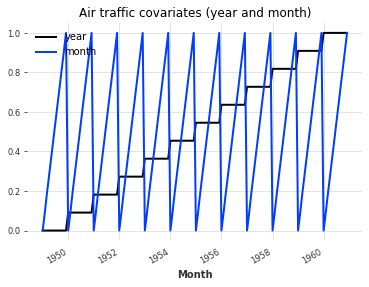

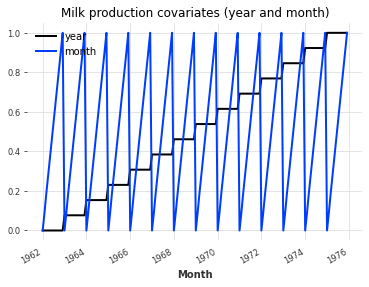

In [17]:
# build year and month series:
air_year = datetime_attribute_timeseries(series_air_scaled, attribute="year")
air_month = datetime_attribute_timeseries(series_air_scaled, attribute="month")

milk_year = datetime_attribute_timeseries(series_milk_scaled, attribute="year")
milk_month = datetime_attribute_timeseries(series_milk_scaled, attribute="month")

# stack year and month to obtain series of 2 dimensions (year and month):
air_covariates = air_year.stack(air_month)
milk_covariates = milk_year.stack(milk_month)

# scale them between 0 and 1:
scaler_dt_air = Scaler()
air_covariates = scaler_dt_air.fit_transform(air_covariates)

scaler_dt_milk = Scaler()
milk_covariates = scaler_dt_milk.fit_transform(milk_covariates)

# split in train/validation sets:
air_train_covariates, air_val_covariates = air_covariates[:-36], air_covariates[-36:]
milk_train_covariates, milk_val_covariates = (
    milk_covariates[:-36],
    milk_covariates[-36:],
)

# plot the covariates:
plt.figure()
air_covariates.plot()
plt.title("Air traffic covariates (year and month)")

plt.figure()
milk_covariates.plot()
plt.title("Milk production covariates (year and month)")

So for each target series (air and milk), we have built a covariates series having the same time axis and containing the year and the month.

Note that here the covariates series are multivariate time series: they contain two dimensions - one dimension for the year and one for the month.

# Training with Covariates

In [18]:
model_cov = BlockRNNModel(
    model="LSTM",
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=300,
    random_state=0,
)

model_cov.fit(
    series=[train_air, train_milk],
    past_covariates=[air_train_covariates, milk_train_covariates],
    verbose=True,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 3.0 K 
4 | fc            | Sequential       | 312   
---------------------------------------------------
3.3 K     Trainable params
0         Non-trainable params
3.3 K     Total params
0.026     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


# Forecasting with Covariates

We can get forecast by specifying the future_covariates argument to the predict() function.

Predicting: 7it [00:00, ?it/s]

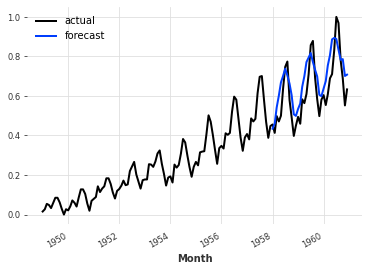

In [19]:
pred_cov = model_cov.predict(n=36, series=train_air, past_covariates=air_covariates)

series_air_scaled.plot(label="actual")
pred_cov.plot(label="forecast")
plt.legend()

# Backtesting with Covariates

We can also backtest the model using covariates. Say for instance we are interested in evaluating the running accuracy with a horizon of 12 months, starting at 75% of the air series.

  0%|          | 0/48 [00:00<?, ?it/s]

Predicting: 7it [00:00, ?it/s]

  2%|▏         | 1/48 [00:00<00:05,  8.06it/s]

Predicting: 7it [00:00, ?it/s]

  4%|▍         | 2/48 [00:00<00:06,  7.25it/s]

Predicting: 7it [00:00, ?it/s]

  6%|▋         | 3/48 [00:00<00:06,  6.92it/s]

Predicting: 7it [00:00, ?it/s]

  8%|▊         | 4/48 [00:00<00:06,  6.77it/s]

Predicting: 7it [00:00, ?it/s]

 10%|█         | 5/48 [00:00<00:06,  6.84it/s]

Predicting: 7it [00:00, ?it/s]

 12%|█▎        | 6/48 [00:00<00:06,  6.97it/s]

Predicting: 7it [00:00, ?it/s]

 15%|█▍        | 7/48 [00:01<00:06,  6.80it/s]

Predicting: 7it [00:00, ?it/s]

 17%|█▋        | 8/48 [00:01<00:05,  6.73it/s]

Predicting: 7it [00:00, ?it/s]

 19%|█▉        | 9/48 [00:01<00:05,  6.86it/s]

Predicting: 7it [00:00, ?it/s]

 21%|██        | 10/48 [00:01<00:05,  6.92it/s]

Predicting: 7it [00:00, ?it/s]

 23%|██▎       | 11/48 [00:01<00:05,  7.09it/s]

Predicting: 7it [00:00, ?it/s]

 25%|██▌       | 12/48 [00:01<00:05,  7.05it/s]

Predicting: 7it [00:00, ?it/s]

 27%|██▋       | 13/48 [00:01<00:04,  7.31it/s]

Predicting: 7it [00:00, ?it/s]

 29%|██▉       | 14/48 [00:01<00:04,  7.52it/s]

Predicting: 7it [00:00, ?it/s]

 31%|███▏      | 15/48 [00:02<00:04,  7.69it/s]

Predicting: 7it [00:00, ?it/s]

 33%|███▎      | 16/48 [00:02<00:04,  7.88it/s]

Predicting: 7it [00:00, ?it/s]

 35%|███▌      | 17/48 [00:02<00:03,  7.75it/s]

Predicting: 7it [00:00, ?it/s]

 38%|███▊      | 18/48 [00:02<00:03,  7.97it/s]

Predicting: 7it [00:00, ?it/s]

 40%|███▉      | 19/48 [00:02<00:03,  8.24it/s]

Predicting: 7it [00:00, ?it/s]

 42%|████▏     | 20/48 [00:02<00:03,  8.28it/s]

Predicting: 7it [00:00, ?it/s]

 44%|████▍     | 21/48 [00:02<00:03,  8.40it/s]

Predicting: 7it [00:00, ?it/s]

 46%|████▌     | 22/48 [00:02<00:03,  8.07it/s]

Predicting: 7it [00:00, ?it/s]

 48%|████▊     | 23/48 [00:03<00:03,  8.10it/s]

Predicting: 7it [00:00, ?it/s]

 50%|█████     | 24/48 [00:03<00:02,  8.25it/s]

Predicting: 7it [00:00, ?it/s]

 52%|█████▏    | 25/48 [00:03<00:03,  7.53it/s]

Predicting: 7it [00:00, ?it/s]

 54%|█████▍    | 26/48 [00:03<00:02,  7.41it/s]

Predicting: 7it [00:00, ?it/s]

 56%|█████▋    | 27/48 [00:03<00:02,  7.47it/s]

Predicting: 7it [00:00, ?it/s]

 58%|█████▊    | 28/48 [00:03<00:02,  7.61it/s]

Predicting: 7it [00:00, ?it/s]

 60%|██████    | 29/48 [00:03<00:02,  7.42it/s]

Predicting: 7it [00:00, ?it/s]

 62%|██████▎   | 30/48 [00:04<00:02,  7.39it/s]

Predicting: 7it [00:00, ?it/s]

 65%|██████▍   | 31/48 [00:04<00:02,  7.72it/s]

Predicting: 7it [00:00, ?it/s]

 67%|██████▋   | 32/48 [00:04<00:02,  7.83it/s]

Predicting: 7it [00:00, ?it/s]

 69%|██████▉   | 33/48 [00:04<00:01,  7.82it/s]

Predicting: 7it [00:00, ?it/s]

 71%|███████   | 34/48 [00:04<00:01,  7.77it/s]

Predicting: 7it [00:00, ?it/s]

 73%|███████▎  | 35/48 [00:04<00:01,  7.45it/s]

Predicting: 7it [00:00, ?it/s]

 75%|███████▌  | 36/48 [00:04<00:01,  7.24it/s]

Predicting: 7it [00:00, ?it/s]

 77%|███████▋  | 37/48 [00:04<00:01,  7.32it/s]

Predicting: 7it [00:00, ?it/s]

 79%|███████▉  | 38/48 [00:05<00:01,  7.64it/s]

Predicting: 7it [00:00, ?it/s]

 81%|████████▏ | 39/48 [00:05<00:01,  7.33it/s]

Predicting: 7it [00:00, ?it/s]

 83%|████████▎ | 40/48 [00:05<00:01,  5.99it/s]

Predicting: 7it [00:00, ?it/s]

 85%|████████▌ | 41/48 [00:05<00:01,  4.94it/s]

Predicting: 7it [00:00, ?it/s]

 88%|████████▊ | 42/48 [00:05<00:01,  5.01it/s]

Predicting: 7it [00:00, ?it/s]

 90%|████████▉ | 43/48 [00:06<00:00,  5.44it/s]

Predicting: 7it [00:00, ?it/s]

 92%|█████████▏| 44/48 [00:06<00:00,  6.00it/s]

Predicting: 7it [00:00, ?it/s]

 94%|█████████▍| 45/48 [00:06<00:00,  5.45it/s]

Predicting: 7it [00:00, ?it/s]

 96%|█████████▌| 46/48 [00:06<00:00,  4.83it/s]

Predicting: 7it [00:00, ?it/s]

 98%|█████████▊| 47/48 [00:06<00:00,  4.46it/s]

Predicting: 7it [00:00, ?it/s]

100%|██████████| 48/48 [00:07<00:00,  6.67it/s]


MAPE (using covariates) = 9.40%


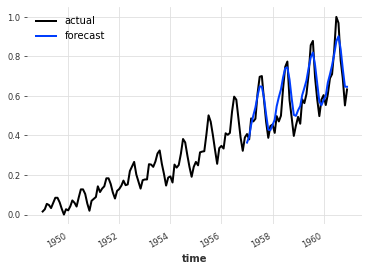

In [21]:
backtest_cov = model_cov.historical_forecasts(
    series_air_scaled,
    past_covariates=air_covariates,
    start=0.6,
    forecast_horizon=12,
    stride=1,
    retrain=False,
    verbose=True,
)

series_air_scaled.plot(label="actual")
backtest_cov.plot(label="forecast")
plt.legend()
print("MAPE (using covariates) = {:.2f}%".format(mape(series_air_scaled, backtest_cov)))
